In [1]:
!nvidia-smi

Tue Jul 30 20:01:23 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import torch
from torch import nn
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

device

'cuda'

## Getting Dataset

In [4]:
#Setting up the training data
train_data = datasets.MNIST(
    root = "data",
    train = True,
    download = True,
    transform = torchvision.transforms.ToTensor(),
    target_transform = None
)

test_data = datasets.MNIST(
    root = "data",
    train = False,
    download = True,
    transform = torchvision.transforms.ToTensor(),
    target_transform = None
)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 15779761.66it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 558798.10it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 3868774.76it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 10750862.74it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [5]:
len(train_data), len(test_data)

(60000, 10000)

In [6]:
image, label = train_data[0]
image, label

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [7]:
class_names = train_data.classes
class_names

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

In [8]:
#Checking the shapes
print(f"Image shape is {image.shape} (Colour Channels, height, width), label is {label}")

Image shape is torch.Size([1, 28, 28]) (Colour Channels, height, width), label is 5


##Visualising the data

Text(0.5, 1.0, '5 - five')

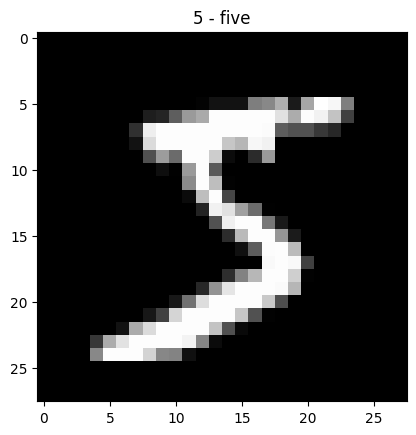

In [9]:
plt.imshow(image.squeeze(), cmap = "gray") #Squeeze necessary as only want height and width
plt.title(class_names[label])

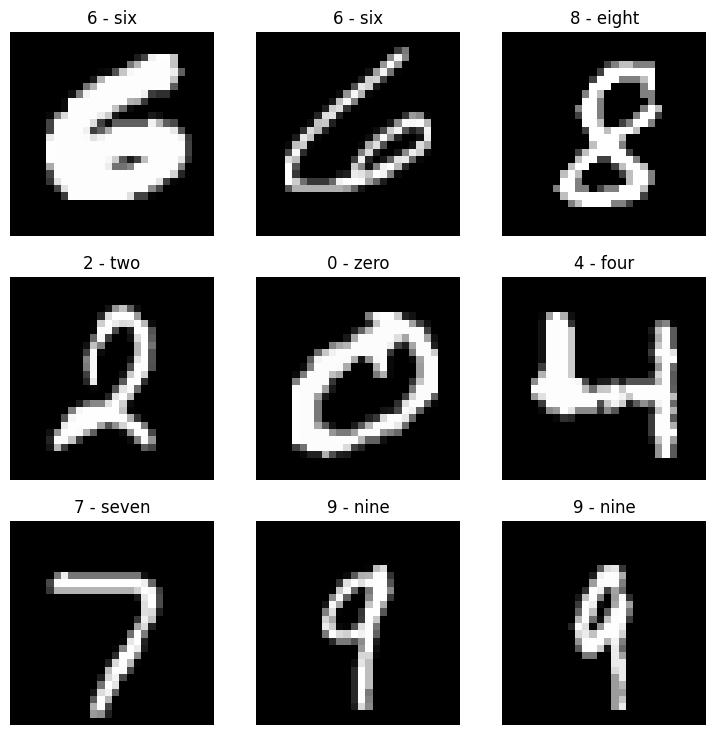

In [10]:
torch.manual_seed(42)
fig = plt.figure(figsize = (9, 9))
rows, cols = 3, 3
for i in range(1, rows*cols + 1):
  random_index = torch.randint(0, len(train_data), size = [1]).item()
  image, label = train_data[random_index]
  fig.add_subplot(rows, cols, i)
  plt.imshow(image.squeeze(), cmap = "gray")
  plt.title(class_names[label])
  plt.axis(False)

## Prepare DataLoader

In [11]:
from torch.utils.data import DataLoader
BATCH_SIZE = 32
#Turn datasets into iterables
train_dataloader = DataLoader(dataset = train_data,
                              batch_size = BATCH_SIZE,
                              shuffle = True)

test_dataloader = DataLoader(dataset = test_data,
                             batch_size = BATCH_SIZE,
                             shuffle = False)

In [12]:
len(train_dataloader), len(test_dataloader)

(1875, 313)

##Creating Model

In [13]:
class MNISTModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv_layer_1 = nn.Sequential(
        nn.Conv2d(in_channels = 1, out_channels = 10, kernel_size = 3, stride = 1, padding = 1),
        #I think will get improvement by reducing the kernel size and by making out_channels 16
        nn.ReLU(),
        nn.Conv2d(in_channels = 10, out_channels = 10, kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2)
    )
    self.conv_layer_2 = nn.Sequential(
        nn.Conv2d(in_channels = 10, out_channels = 10, kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(),
        nn.Conv2d(in_channels = 10, out_channels = 10, kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2)
    )
    self.classifier_layer = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features = 10 * 49,
                  out_features = 10)
    )

  def forward(self, x):
    x = self.conv_layer_1(x)
    x = self.conv_layer_2(x)
    #print(x.shape) #This will tell us the input shape after flatten e.g if printed RuntimeError: mat1 and mat2 shapes cannot be multiplied (10x49 and 10x10)
    #Through this we know that after flatten we will get 10 * 49 so we know that in_features for linear need to be 10 * 49
    x = self.classifier_layer(x)
    #print(x.shape)
    return x

In [14]:
model_0 = MNISTModel()
model_0.to(device)

MNISTModel(
  (conv_layer_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier_layer): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [15]:
rand_image_tensor = torch.randn(size = (1, 28, 28))
model_0(rand_image_tensor.unsqueeze(dim = 0).to(device))

tensor([[ 0.0445, -0.0445,  0.0196,  0.0050,  0.0869,  0.0225, -0.0861,  0.0680,
         -0.0555,  0.0400]], device='cuda:0', grad_fn=<AddmmBackward0>)

### Loss function and optimizer

In [16]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  # Note: you need the "raw" GitHub URL for this to work
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

In [17]:
#Importing accuracy metric from helper functions
from helper_functions import accuracy_fn
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = model_0.parameters(),
                            lr = 0.1)

In [26]:
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn):
  loss, acc = 0, 0
  model.to(device)
  model.eval()
  with torch.inference_mode():
    for X, y in data_loader:
      X = X.to(device)
      y = y.to(device)
      y_pred = model(X)
      loss += loss_fn(y_pred, y)
      acc += accuracy_fn(y_true = y, y_pred = y_pred.argmax(dim = 1))

    loss /= len(data_loader)
    acc /= len(data_loader)

  return {"model_name": model.__class__.__name__, #Only works when model was created with a class
          "model_loss": loss.item(), #Scaled to a single value by .item()
          "model_accuracy": acc}

In [19]:
from timeit import default_timer as timer
def print_train_time(start: float, end: float, device: torch.device = None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format).
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

##Training and testing loop

In [21]:
from tqdm.auto import tqdm
torch.manual_seed(42)
torch.cuda.manual_seed(42)
train_time_start_cpu = timer()
epochs = 3
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch} \n")
  train_loss = 0
  for batch, (X, y) in enumerate(train_dataloader):
    X, y = X.to(device), y.to(device)
    model_0.train()
    #1. Forward Pass
    y_logits = model_0(X)

    #2. Calculate Loss
    loss = loss_fn(y_logits, y)
    train_loss += loss

    #3. Optimizer zero grad
    optimizer.zero_grad()

    #4. Loss Backwards
    loss.backward()

    #5. Optimizer Step
    optimizer.step()

    if batch % 400 == 0:
      print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")
      # batch * len(X) : Total number of samples processed so far
      # len(train_dataloader.dataset) : Total number of items we have in our dataset

  train_loss /= len(train_dataloader)

  ###Testing
  test_loss, test_acc = 0, 0
  model_0.eval()
  with torch.inference_mode():
    for batch, (X, y) in enumerate(test_dataloader):
      X, y = X.to(device), y.to(device)
      #1. Forward Pass
      test_pred = model_0(X)
      #2. Calculate Loss
      loss = loss_fn(test_pred, y)
      test_loss += loss
      test_acc += accuracy_fn(y_true = y, y_pred = test_pred.argmax(dim = 1))

    test_loss /= len(test_dataloader)
    test_acc /= len(test_dataloader)

  print(f"\nTrain loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%\n")

train_time_end_cpu = timer()
total_train_time_model_0 = print_train_time(start=train_time_start_cpu,
                                           end=train_time_end_cpu,
                                           device=str(next(model_0.parameters()).device))

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0 

Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.07918 | Test loss: 0.06265, Test acc: 97.94%

Epoch: 1 

Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.06100 | Test loss: 0.04416, Test acc: 98.57%

Epoch: 2 

Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.05103 | Test loss: 0.04758, Test acc: 98.47%

Train time on cuda:0: 35.345 seconds


## Evaluating the model

In [27]:
eval_model(model = model_0, data_loader = test_dataloader, loss_fn = loss_fn, accuracy_fn = accuracy_fn)

{'model_name': 'MNISTModel',
 'model_loss': 0.04758011922240257,
 'model_accuracy': 98.47244408945687}

In [42]:
def make_predictions(model: torch.nn.Module,
                     data: list,
                     device: torch.device = device):
  pred_probs = []
  model.to(device)
  model.eval()
  with torch.inference_mode():
    for sample in data:
      #print(sample.shape)
      sample = torch.unsqueeze(sample, dim = 0).to(device) #Unsqueeze to add batch dimensionality
      #print(sample.shape)
      pred_logit = model(sample)
      #print(pred_logit) #Will have 10 logits for probabilities of the 10 possible outputs in shape [1, 10] so need to squeeze in softmax
      #print(f"Logit shape is : {pred_logit.shape}")
      pred_prob = torch.softmax(pred_logit.squeeze(), dim = 0)

      pred_probs.append(pred_prob.cpu())

  return torch.stack(pred_probs)

In [30]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [35]:
import random
random.seed(42)
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k = 9):
  test_samples.append(sample)
  test_labels.append(label)

#View the first sample shape
test_samples[8].shape

torch.Size([1, 28, 28])

Text(0.5, 1.0, '2 - two')

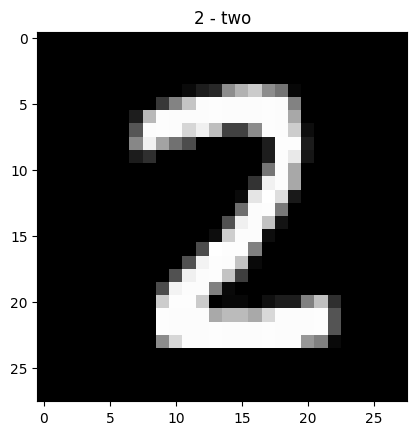

In [36]:
plt.imshow(test_samples[0].squeeze(), cmap = "gray")
plt.title(class_names[test_labels[0]])

In [43]:
pred_probs = make_predictions(model = model_0,
                              data = test_samples)

pred_probs[:2]

tensor([[5.6812e-10, 2.9845e-07, 1.0000e+00, 2.4446e-08, 1.2330e-13, 2.3677e-16,
         1.4534e-13, 5.7232e-08, 6.7172e-08, 5.2059e-12],
        [3.2805e-07, 9.9659e-01, 2.1306e-06, 8.3816e-06, 4.6168e-04, 1.1504e-03,
         1.0646e-04, 9.1107e-06, 1.4215e-03, 2.5309e-04]])

In [44]:
#Convert prediction probabilities to labels
pred_classes = pred_probs.argmax(dim = 1)
pred_classes

tensor([2, 1, 2, 4, 6, 6, 4, 9, 1])

In [45]:
test_labels

[2, 1, 2, 4, 6, 6, 4, 9, 1]

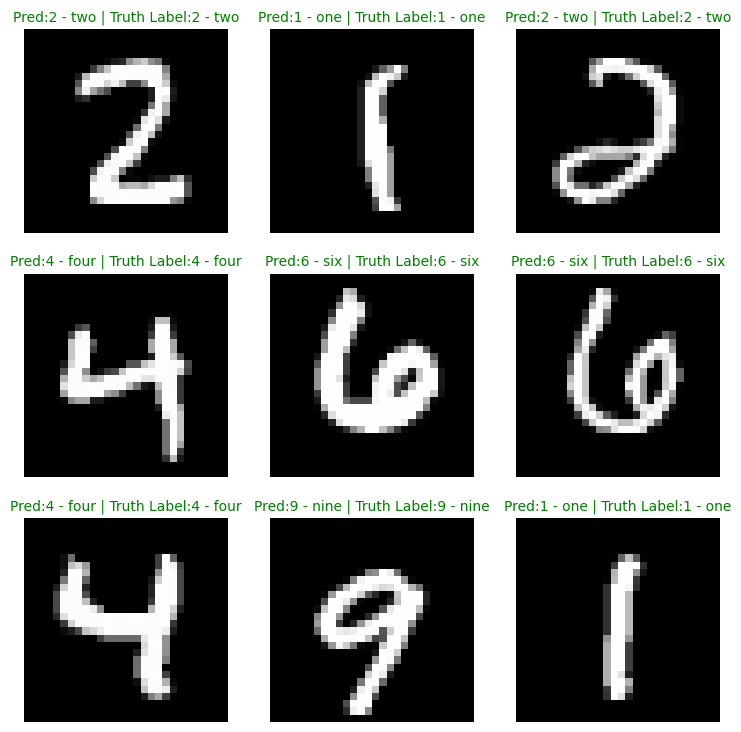

In [54]:
#Plot predictions
plt.figure(figsize = (9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
  plt.subplot(nrows, ncols, i + 1)
  plt.imshow(sample.squeeze(), cmap = "gray")

  pred_label = class_names[pred_classes[i]]
  truth_label = class_names[test_labels[i]]

  title_text = f"Pred:{pred_label} | Truth Label:{truth_label}"
  if pred_label == truth_label:
    plt.title(title_text, fontsize = 10, c = "g") #Green text if prediction same as truth
  else:
    plt.title(title_text, fontsize = 10, c = "r") #Red text if prediction is wrong

  plt.axis(False)

## Making confusion matrix

In [48]:
import mlxtend
from tqdm.auto import tqdm
#1. Make predictions
y_preds = []
model_0.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc = "Making Predictions"):
    #Send the data to target device
    X, y = X.to(device), y.to(device)
    #Forward pass
    y_logit = model_0(X)
    #Turn predictions from logits to prediction probabilities to prediction labels
    y_pred = torch.softmax(y_logit.squeeze(), dim = 0).argmax(dim = 1)
    #Put predictions on cpu for evaluations
    y_preds.append(y_pred.cpu())

#print(y_preds)
y_preds_tensor = torch.cat(y_preds) #Concatenate all the predictions for the batches into one single tensor with 1 dimension
y_preds_tensor[:5]

Making Predictions:   0%|          | 0/313 [00:00<?, ?it/s]

tensor([7, 2, 1, 0, 4])

In [62]:
len(y_preds_tensor), y_preds_tensor.shape

(10000, torch.Size([10000]))

In [49]:
try:
  import torchmetrics, mlxtend
  print(mlxtend.__version__)
except:
  !pip install -U mlxtend -q torchmetrics
  print(f"{mlxtend.__version__}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 17.7 MB/s eta 0:00:00
0.23.1


In [51]:
test_data.targets

tensor([7, 2, 1,  ..., 4, 5, 6])

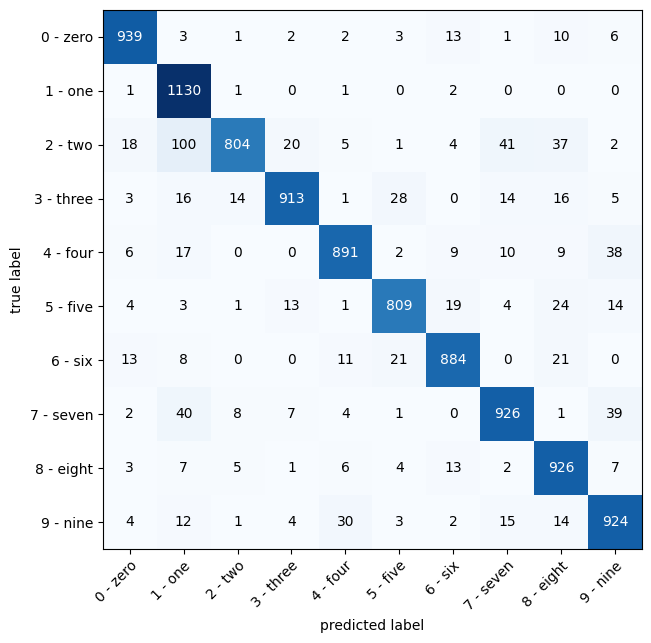

In [52]:
import mlxtend
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

#2. Setup Confusion Matrix instance and evaluate the model (compare predictions to targets)

confmat = ConfusionMatrix(num_classes = len(class_names), task = "multiclass")
confmat_tensor = confmat(preds = y_preds_tensor,
                         target = test_data.targets)

#3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat = confmat_tensor.numpy(), #motplotlib works with numpy
    class_names = class_names,
    figsize = (10, 7)
)

In [55]:
# Get wrong prediction indexes
import numpy as np
wrong_pred_indexes = np.where(y_preds_tensor.cpu() != test_data.targets)[0]
len(wrong_pred_indexes)

854

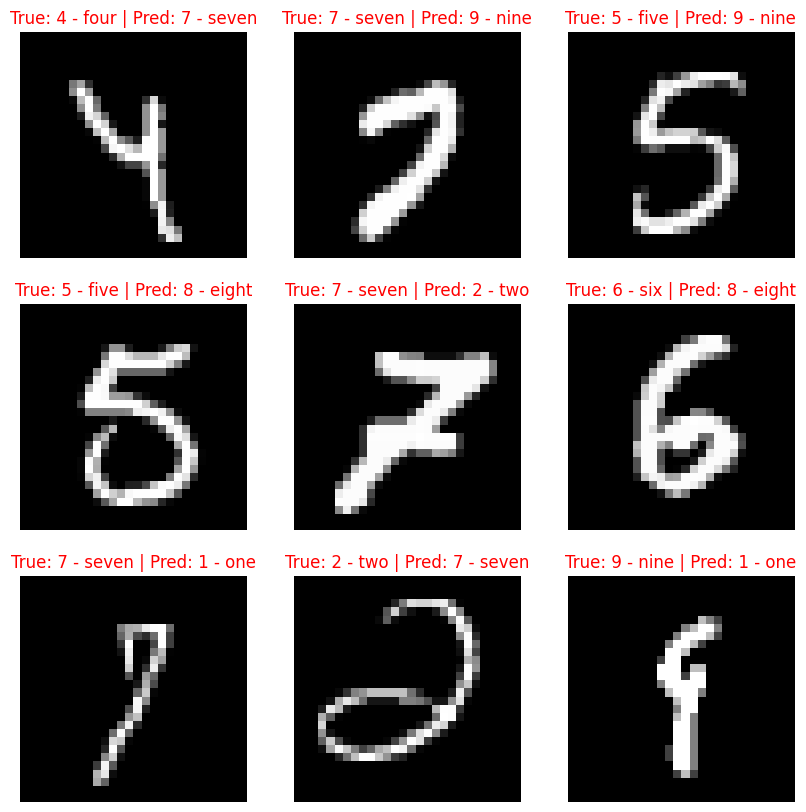

In [59]:
# Select random 9 wrong predictions and plot them
import random
random_selection = random.sample(list(wrong_pred_indexes), k=9)

plt.figure(figsize=(10, 10))
for i, idx in enumerate(random_selection):
  # Get true and pred labels
  true_label = class_names[test_data[idx][1]]
  pred_label = class_names[y_preds_tensor[idx]]

  # Plot the wrong prediction with its original label
  plt.subplot(3, 3, i+1)
  plt.imshow(test_data[idx][0].squeeze(), cmap="gray")
  plt.title(f"True: {true_label} | Pred: {pred_label}", c="r")
  plt.axis(False);

In [65]:
from pathlib import Path
#Create model directory path
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents = True,
                 exist_ok = True)

#Create Model save path
MODEL_NAME = "03_pytorch_computer_vision_exercise.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

MODEL_SAVE_PATH

#Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj = model_0.state_dict(),
           f = MODEL_SAVE_PATH)

Saving model to: models/03_pytorch_computer_vision_exercise.pth


In [67]:
#Loading the model
torch.manual_seed(42)
loaded_model_0 = MNISTModel()
loaded_model_0.load_state_dict(torch.load(f = MODEL_SAVE_PATH))

#Send the model to target device
loaded_model_0.to(device)


MNISTModel(
  (conv_layer_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier_layer): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)